In [ ]:
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np
import os
import sys

path_to_this_notebook = os.path.abspath('.')
path_to_project = path_to_this_notebook[:path_to_this_notebook.find('note')]
sys.path.append(path_to_project)
%load_ext autoreload
%autoreload 2

In [2]:
from src.problems.single_node_evcp.executors.greedy_executor import GreedyQuadraticExecutor
from src.problems.single_node_evcp.executors.two_stage_executor import TwoStageExecutor
from src.problems.single_node_evcp.data_samplers.load_samplers import load_samplers
from src.problems.single_node_evcp.create_env import create_single_node_env

from src.rl.agents.td3 import TD3Agent
from src.rl.memory.trajectory_replay_buffer import TrajectoryMemoryBuffer
from src.rl.memory.transition_replay_buffer import TransitionMemoryBuffer

USING DEVICE cpu


In [3]:
def get_rl_state(env):
    p_lbs_t, p_ubs_t = env.get_power_bounds()
    u_t = env.get_utility_coefficients()
    s  = [float(env.t_hr)/24]
    for d_ind in range(env.n_devices):
        demand = 0
        time_to_charge = 0
        if env.devices[d_ind].type == 'ev_charger':
            ev_ind  = env.devices[d_ind].info['current_episode_data'][env.t_str]
            if ev_ind is None or np.isnan(ev_ind):
                pass
            else:
                ev = env.devices[d_ind].info['current_episode_evs_dict'][ev_ind]
                demand = env.devices[-1].info['current_episode_evs_dict'][0].free_space
                time_to_charge = (env.devices[-1].info['current_episode_evs_dict'][0].t_dep_hr - env.t_hr)
                time_to_charge = time_to_charge if time_to_charge >= 0 else time_to_charge + 24
        s.extend((u_t[d_ind], p_lbs_t[d_ind]/10, p_ubs_t[d_ind]/10, demand/10, time_to_charge/24))
    #print('state', np.round(s))
    return np.array(s)

In [4]:
############################################# Config #############################################

config = {'path_to_data': path_to_project + '/data/', 
          't0_hr': 6.,
          'dt_min': 120,
          'ev_dt_min': 120,
          'ev_sampling_dt_min': 60, 
          'apply_gaussian_noise': False,
          'ev_utility_coef_mean': 1,
          'ev_utility_coef_scale': 0.13,
          'days_per_month_train': 20,
          'ev_session_months_train': ['01', '02', '03', '04', '06', '07', '08', '09', '10', '11',],
          'ev_session_months_test': ['05', '12'],
          'n_ps_pvs': 1,
          'ps_pvs_rated_power': 15,
          'n_canopy_pvs': 0,
          'canopy_pv_rated_power': 250,
          'n_loads': 0,
          'n_feeders': 1,
          'feeder_p_min': -3,
          'n_ev_chargers': 5,
          'avg_evs_per_day': 3.5,
          }

In [5]:
# Preaload samplers, it is necessary to avoid re-reading data each time env is created
(ps_samplers_dict, ps_metadata, canopy_sampler, canopy_metadata,
 price_sampler, price_metadata, ev_sampler, elaadnl_metadata) = load_samplers(config)

In [6]:
seed = 422
env = create_single_node_env(config, ps_samplers_dict, ps_metadata, canopy_sampler, canopy_metadata,
                             price_sampler, price_metadata, ev_sampler, elaadnl_metadata, seed=seed)

In [27]:
import time 
import torch

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def parse_sample_dict(sample_dict):
    # state = sample_dict['state']
    # state_next = sample_dict['state_next']
    observations = sample_dict['observations']
    observations_next = sample_dict['observations_next']
    actions = sample_dict['actions']
    dones = sample_dict['done']
    reset_mask = sample_dict['reset_mask']
    rewards = sample_dict['reward']
    observations_extended = np.concatenate([observations, observations_next[:, -1:]], axis=1)
    reset_mask_extended = np.concatenate([reset_mask, dones[:, -1:]], axis=1)
    # state_extended = np.concatenate([state, state_next[:, -1:]], axis=1)
    # state_extended = torch.tensor(state_extended, dtype=torch.float32).to(device)
    observations_extended = torch.tensor(observations_extended, dtype=torch.float32).to(DEVICE)
    actions = torch.tensor(actions,  dtype=torch.float32).to(DEVICE)
    rewards = torch.tensor(rewards,  dtype=torch.float32).to(DEVICE)
    dones = torch.tensor(dones,  dtype=torch.float32).to(DEVICE)
    reset_mask_extended = torch.tensor(reset_mask_extended,  dtype=torch.float32).to(DEVICE)

    return observations_extended, actions, rewards, dones, reset_mask_extended


def run_episode(agent, memory, greedy_executor, env, episode_index, 
                use_train_data=True, train_agent=True, batch_size=16):
    env.reset(episode_index=episode_index, train=use_train_data)
    obs = get_rl_state(env)
    hidden_state = agent.actor.get_initial_state(1)
    done = False
    reset_mask = True
    episode_results = {'reward': 0, 'length': 0, 'env_time': 0, 'sampling_time': 0, 'training_time': 0, }
    if train_agent:
        memory.start_episode()

    while not done:
        action, hidden_state = agent.select_action(torch.tensor(obs).reshape((1, 1, -1)).float().to(DEVICE),
                                                   hidden_state, noisy=train_agent, use_target=False)
        action = action.cpu().detach().numpy().reshape(-1)
        # print('a', action.round(2))
        t = time.time()
        params = {'alpha_linear': np.array(action[:env.n_devices]),  
                  'alpha_square': np.array(action[env.n_devices:])}
        greedy_executor.update_params(params)
        p = greedy_executor.compute_solution(env)
        result = env.step(p)
        
        obs_next = get_rl_state(env)
        reward = result['reward']
        done = bool(env.done)
        episode_results['env_time'] += time.time() - t
        episode_results['reward'] += float(reward)
        episode_results['length'] += 1
        
        transition_dict = {'observations': obs.reshape(-1),
                               'observations_next': obs_next.reshape(-1),
                               'actions': action,
                               'done': np.reshape(done, -1),
                               'reward': np.reshape(reward, -1),
                               'reset_mask': np.reshape(reset_mask, -1)}
        if train_agent:
            memory.observe_transition(transition_dict)
            if done:
                memory.finish_episode()
        if train_agent and memory.can_sample:
            t = time.time()
            sample_dict = memory.sample_batch(batch_size)
            (observations_extended, actions, rewards,
            dones, reset_mask_extended) = parse_sample_dict(sample_dict)
            episode_results['sampling_time'] += time.time() - t
            t = time.time()
            agent.train(observations_extended, actions, rewards, dones, reset_mask_extended)
            episode_results['training_time'] += time.time() - t
        obs = obs_next
        reset_mask = bool(done)
        
    return episode_results

In [8]:
observation_dim = env.n_devices * 5 + 1
action_dim =  env.n_devices * 2
max_action_value = 3

scheme = {'observations': observation_dim, 
          'observations_next': observation_dim,
          'actions':action_dim,
          'done': (1, ), 'reward': (1, ), 'reset_mask': (1, )}

In [35]:
two_stage_executor = TwoStageExecutor()
greedy_executor = GreedyQuadraticExecutor()

memory_trans = TransitionMemoryBuffer(scheme=scheme, max_size=int(1e6), min_size_to_sample=512, 
                                      sample_during_episode=True)

memory_traj = TrajectoryMemoryBuffer(scheme=scheme, max_size=int(1e6), min_size_to_sample=64, 
                                     sample_during_episode=True)
lstm_dims_list = [64]
hidden_dims_list = [256]

agent = TD3Agent(observation_dim, action_dim, max_action_value, lstm_dims_list, hidden_dims_list,
                 actor_lr=3e-4, critic_lr=3e-4,  discount=0.99, tau=0.005,
                 policy_noise=0.35, noise_clip=.7, policy_update_freq=2)
batch_size = 32

In [36]:
training_episodes = np.arange(0, 9999999, 1)
test_episodes = np.arange(0, 30, 1)

In [ ]:
print_each = 100

keys_to_print = ['reward']        
test_each = 300

test_results = defaultdict(list)
train_results = defaultdict(list)

for episode_index in training_episodes:
    episode_results = run_episode(agent, memory_traj, greedy_executor, env, episode_index, 
                                  use_train_data=True, train_agent=True, batch_size=batch_size)
    for key, val in episode_results.items():
        train_results[key].append(val)
        
    if episode_index % print_each == 0:
        print('Training episode %d    ' % episode_index)
        for key in keys_to_print:
            print('    %s=%.2f' % (key, np.mean(train_results[key][-print_each:])))
        print()
        
    if episode_index % test_each == 0:
        current_test_results = defaultdict(list)
        for test_episode_index in test_episodes:
            episode_results = run_episode(agent, memory_trans, greedy_executor, env, test_episode_index, 
                                      use_train_data=False, train_agent=False, batch_size=batch_size)
            for key, val in episode_results.items():
                current_test_results[key].append(val)
        current_test_results = {key: np.mean(val) for key, val in current_test_results.items()}
        print('Test run after episode %d:' % episode_index)
        for key in keys_to_print:
            print('    %s=%.2f' % (key, current_test_results[key]))
            test_results[key].append(current_test_results[key])
        print()

Training episode 0    
    reward=43.99

Test run after episode 0:
    reward=68.14

Training episode 100    
    reward=67.03



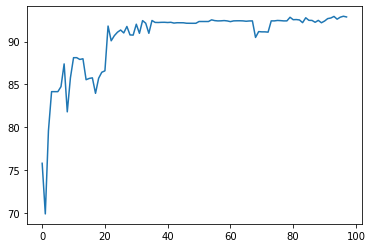

In [13]:
plt.plot(test_results['reward'])

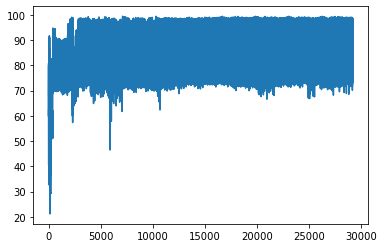

In [12]:
plt.plot(train_results['reward'])

In [31]:
test_episode_index = 4
episode_results = run_episode(agent, memory_trans, greedy_executor, env, test_episode_index,
                              use_train_data=False, train_agent=False, batch_size=batch_size)
episode_results

{'reward': 95.49760887865044,
 'length': 11,
 'env_time': 1.2162525653839111,
 'sampling_time': 0,
 'training_time': 0}

In [32]:
    ep_reward = 0
    env.reset(episode_index=test_episode_index, train=False)
    params = {'alpha_linear': np.ones(env.n_devices), 
              'alpha_square': np.zeros(env.n_devices)}
    greedy_executor.update_params(params)
    while not env.done:
        p = greedy_executor.compute_solution(env)
        result_t = env.step(p)
        ep_reward += result_t['reward']
    print(ep_reward)

94.281255742231


In [33]:
    ep_reward = 0
    env.reset(episode_index=test_episode_index, train=False)
    evs_dict = env.get_all_evs_dict()
    p_lbs, p_ubs, u = env.compute_full_state()
    evs_dict = [evs_dict for _ in range(len(u))]
    params = {'p_lbs': p_lbs, 'p_ubs': p_ubs, 'u': u, 'evs_dict': evs_dict}
    two_stage_executor.update_params(params)
    while not env.done:
        p = two_stage_executor.compute_solution(env)
        result_t = env.step(p)
        ep_reward += result_t['reward']
    print(ep_reward)

97.83514346172937


In [172]:
test_results['reward'][-10:]

[106.59499662775784,
 106.59499662729449,
 106.59499662741207,
 106.59499662722673,
 108.28374111182677,
 108.28374111189964,
 108.28374113851879,
 108.6037736342767,
 102.61031511400039,
 102.61031511484263]

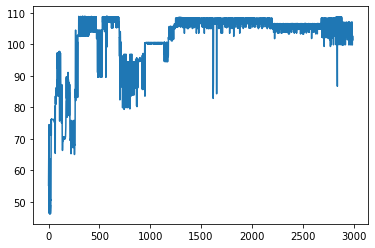

In [170]:
plt.plot(train_results['reward'])

In [7]:
import time 

def run_training_episode(env, agent, episode_index, is_warmup, use_train=True, seed=None):
    agent.is_training = True
    if seed is not None:
        np.random.seed(seed)
    env.reset(episode_index=episode_index, train=use_train)
    if seed is not None:
        np.random.seed(int(1000 * time.time()) % 2**32)
    state = get_rl_state(env)
    agent.reset(state)
    ep_reward = 0
    while not env.done:
        # Choose action
        if is_warmup:
            action = agent.random_action()
        else:
            action = agent.select_action(state)
        # Run action
        params = {'alpha_linear': np.array(action[:env.n_devices]),  
                  'alpha_square': np.array(action[env.n_devices:])}
        greedy_executor.update_params(params)
        p = greedy_executor.compute_solution(env)
        result = env.step(p)
        # Process transition
        next_state = get_rl_state(env)
        reward = result['reward']
        done = bool(env.done)
        agent.observe(reward, next_state, done)      
        if not is_warmup:
            agent.update_policy()
        # Save result
        ep_reward += reward
        state = next_state
    agent.memory.append(state, agent.select_action(state), 0., False)
    return ep_reward

def run_test_episode(env, agent, episode_index, use_train=True, seed=None):
    agent.is_training = False
    if seed is not None:
        np.random.seed(seed)
    env.reset(episode_index=episode_index, train=use_train)
    if seed is not None:
        np.random.seed(int(1000 * time.time()) % 2**32)
    state = get_rl_state(env)
    agent.reset(state)
    ep_reward = 0
    while not env.done:
        # Choose action
        action = agent.select_action(state)
        # Run action
        params = {'alpha_linear': np.array(action[:env.n_devices]),  
                  'alpha_square': np.array(action[env.n_devices:])}
        greedy_executor.update_params(params)
        p = greedy_executor.compute_solution(env)
        result = env.step(p)
        # Process transition
        next_state = get_rl_state(env)
        reward = result['reward']
        # Save result
        ep_reward += reward
        state = next_state

    return ep_reward


def run_greedy_executor(env, greedy_executor, episode_index, use_train=True, seed=None):
    ep_reward = 0
    if seed is not None:
        np.random.seed(seed)
    env.reset(episode_index=episode_index, train=use_train)
    params = {'alpha_linear': np.ones(env.n_devices), 
              'alpha_square': np.zeros(env.n_devices)}
    greedy_executor.update_params(params)
    while not env.done:
        p = greedy_executor.compute_solution(env)
        result_t = env.step(p)
        ep_reward += result_t['reward']
    return ep_reward


def run_two_stage_executor(env, two_stage_executor, episode_index, use_train=True, seed=None):
    ep_reward = 0
    if seed is not None:
        np.random.seed(seed)
    env.reset(episode_index=episode_index, train=use_train)
    evs_dict = env.get_all_evs_dict()
    p_lbs, p_ubs, u = env.compute_full_state()
    evs_dict = [evs_dict for _ in range(len(u))]
    params = {'p_lbs': p_lbs, 'p_ubs': p_ubs, 'u': u, 'evs_dict': evs_dict}
    two_stage_executor.update_params(params)
    while not env.done:
        p = two_stage_executor.compute_solution(env)
        result_t = env.step(p)
        ep_reward += result_t['reward']
    return ep_reward

In [8]:
def plot_results(env, results_list, figsize=(12, 7)):
    plt.figure(figsize=figsize)
    plt.subplot(121)
    # i_violations = [res['i_constraints_violation'] for res in results_list]
    p_violations = [res['power_flow_constraints_violation'] for res in results_list]
    # plt.plot(env.timesteps_str[:-1], i_violations, label='i_violation')
    plt.plot(env.timesteps_str[:-1], p_violations, label='p_violation')
    _ = plt.xticks(env.timesteps_str[::6])
    _ = plt.legend()
    _ = plt.title('Constraint violations')

    plt.subplot(122)
    rewards = [res['reward'] for res in results_list]
    feeders_price = [res['feeders_power_price'] for res in results_list]
    pvs_price = [res['pvs_power_price'] for res in results_list]
    evs_welfare = [res['evs_social_welfare'] for res in results_list]

    plt.plot(env.timesteps_str[:-1], rewards, label='total reward')
    plt.plot(env.timesteps_str[:-1], feeders_price, label='feeders price')
    plt.plot(env.timesteps_str[:-1], pvs_price, label='PVs price')
    plt.plot(env.timesteps_str[:-1], evs_welfare, label='EVs welfare')
    _ = plt.xticks(env.timesteps_str[::6])
    _ = plt.legend()
    _ = plt.title('Objective')

In [9]:
def create_agent():
    agent = DDPG(env.n_devices * 5 + 1, env.n_devices * 2, hidden1=128, hidden2=128, init_w=1e-3,
              rmsize=int(1e6), window_length=1, bsize=256, tau=1e-2, epsilon=20000,
              ou_theta=0.1, ou_mu=0, ou_sigma=.55)
    return agent

training_episodes = np.arange(0, 1000000, 1)
#training_episodes = np.arange(0, 1)
# training_episodes = [0]
test_episodes = np.arange(15)
#test_episodes = [0]
seed = 7225
use_train_for_test = False

In [10]:
env = create_single_node_env(config, ps_samplers_dict, ps_metadata, canopy_sampler, canopy_metadata,
                             price_sampler, price_metadata, ev_sampler, elaadnl_metadata)

In [14]:
from src.rl.ddpg.ddpg import DDPG
greedy_executor = GreedyQuadraticExecutor()
two_stage_executor = TwoStageExecutor()
agent = create_agent()

In [15]:
test_results_greedy = []
test_results_twostage = []
for episode_index in test_episodes:
    ep_reward_greedy = run_greedy_executor(env, greedy_executor, episode_index, use_train_for_test, seed)
    ep_reward_twostage = run_two_stage_executor(env, two_stage_executor, episode_index, use_train_for_test, seed)
    test_results_greedy.append(ep_reward_greedy)
    test_results_twostage.append(ep_reward_twostage)
print(np.mean(test_results_greedy))
print(np.mean(test_results_twostage))

77.75226361930537
89.22964295729088


In [16]:
warmup_episodes = 500
test_every = 250

training_rewards = []
test_rewards = []

for training_epoch in range(0, 100000):
    episode_index = np.random.choice(training_episodes)
    is_warmup = training_epoch < warmup_episodes
    ep_reward = run_training_episode(env, agent, episode_index, is_warmup, use_train=True, seed=seed)
    # print(episode_index, 'R=%.2f' % ep_reward)
    if training_epoch % test_every == 0:
        test_results = []
        for episode_index in test_episodes:
            ep_reward = run_test_episode(env, agent, episode_index, use_train=use_train_for_test, seed=seed)
            test_results.append(ep_reward)
        print('Test result after epoch %d: %.2f / %.2f / %.2f' % (training_epoch, 
                                                                  np.mean(test_results), 
                                                                  np.mean(test_results_greedy), 
                                                                  np.mean(test_results_twostage)))
        test_rewards.append(np.mean(test_results))
    training_rewards.append(ep_reward)

Test result after epoch 0: 46.50 / 77.75 / 89.23
Test result after epoch 250: 46.50 / 77.75 / 89.23
Test result after epoch 500: 44.78 / 77.75 / 89.23
Test result after epoch 750: 77.60 / 77.75 / 89.23
Test result after epoch 1000: 73.68 / 77.75 / 89.23
Test result after epoch 1250: 82.24 / 77.75 / 89.23
Test result after epoch 1500: 82.08 / 77.75 / 89.23
Test result after epoch 1750: 77.53 / 77.75 / 89.23
Test result after epoch 2000: 82.89 / 77.75 / 89.23
Test result after epoch 2250: 82.89 / 77.75 / 89.23
Test result after epoch 2500: 82.89 / 77.75 / 89.23
Test result after epoch 2750: 82.89 / 77.75 / 89.23
Test result after epoch 3000: 82.89 / 77.75 / 89.23
Test result after epoch 3250: 82.89 / 77.75 / 89.23
Test result after epoch 3500: 82.89 / 77.75 / 89.23
Test result after epoch 3750: 82.89 / 77.75 / 89.23
Test result after epoch 4000: 82.89 / 77.75 / 89.23
Test result after epoch 4250: 82.89 / 77.75 / 89.23
Test result after epoch 4500: 82.89 / 77.75 / 89.23
Test result after 


KeyboardInterrupt



In [17]:
use_train_for_test = True
test_results_greedy = []
test_results_twostage = []
for episode_index in test_episodes:
    ep_reward_greedy = run_greedy_executor(env, greedy_executor, episode_index, use_train_for_test, seed)
    ep_reward_twostage = run_two_stage_executor(env, two_stage_executor, episode_index, use_train_for_test, seed)
    test_results_greedy.append(ep_reward_greedy)
    test_results_twostage.append(ep_reward_twostage)
print(np.mean(test_results_greedy))
print(np.mean(test_results_twostage))

73.88042475349724
85.74845167246544
